In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline

In [2]:
data_file = '/Users/nevinaresh/Documents/CPET Research/BxBData.json'
outcomes_file = '/Users/nevinaresh/Documents/CPET Research/CPX database_outcomes_meds_10_22.xlsx'

In [138]:
#reads in the data from the json file
raw_data = pd.read_json(data_file).transpose()

In [139]:
raw_data.shape

(4221, 54)

In [140]:
#formats columns and removes unnecessary
from src.jsonParsing import preprocess

preprocessed_data = preprocess(raw_data)

In [141]:
preprocessed_data.shape

(4220, 56)

In [142]:
#preprocessed_data[preprocessed_data['testDate'] == pd.to_datetime('10/11/2016', format='%m/%d/%Y')]

In [143]:
#filters those rows that have an ID1 of the form 'MRN-'MRNID
from src.jsonParsing import validmrn

data_with_mrn = validmrn(preprocessed_data)

/Users/nevinaresh/Documents/Stanford/CPET-AI/src/jsonParsing.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_mrn['MRN'] = pd.to_numeric(valid_mrn['ID1'].str.split('-').str[1], errors='coerce')


In [144]:
data_with_mrn.shape

(3882, 58)

In [145]:
x = preprocessed_data[preprocessed_data['testDate'] == pd.to_datetime("10/11/2016", format='%m/%d/%Y')]

In [146]:
outcomes_data = pd.read_excel(outcomes_file, sheet_name="Outcomes_updated")

In [147]:
cpx = pd.read_excel(outcomes_file, sheet_name="CPX")
hcm = cpx[cpx['CPX_diagnosis_Cat1'] == 'HCM']
hcm_mrn = hcm['MRN']
hf = cpx[cpx['CPX_diagnosis_Cat1'] == 'HF']
hf_mrn = hf['MRN']
cong = cpx[cpx['CPX_diagnosis_Cat1'] == 'Cong']
cong_mrn = cong['MRN']

In [148]:
x = outcomes_data[outcomes_data['Test Date'] == pd.to_datetime("10/11/2016", format='%m/%d/%Y')]

In [150]:
from src.outcomeParsing import preprocess

death_data = preprocess(outcomes_data)

In [151]:
composite_outcome_columns = [
    "post_cardiac_arrest",
    "post_cardiogenic_shock",
    "post_ecmo",
    "post_heart_lung_transplant",
    "post_htx",
    "post_iabp",
    "post_mcs_extracardiac",
    "post_mcs_implantable",
    "post_mcs_percutaneous",
    "post_renal_failure_requiring_dialysis",
    "post_shockable_rhythm",
    "post_ventricular_fib_flut"
]

In [152]:
outcome_copy = outcomes_data.copy().dropna(subset=composite_outcome_columns)
outcome_copy['composite_outcome'] = outcome_copy[composite_outcome_columns].max(axis=1)

In [153]:
from src.outcomeParsing import mergeDataOutcome

#alternative outcomes where we have more data (death, cardiovascular related hospitalization)
data_and_outcomes = mergeDataOutcome(data_with_mrn, death_data, 365*7)

In [154]:
data_and_outcomes = data_and_outcomes.merge(outcome_copy[['MRN', 'composite_outcome']], on='MRN', how='left').drop_duplicates(subset=['firstName', 'MRN', 'testDate', 'composite_outcome'], keep='first')

In [155]:
x = data_and_outcomes[data_and_outcomes['MRN'].isin(cong_mrn)]

In [156]:
data_and_outcomes['Death'].value_counts(), data_and_outcomes['composite_outcome'].value_counts()

(Death
 0    3834
 1     101
 Name: count, dtype: int64,
 composite_outcome
 0.0    2770
 1.0     671
 Name: count, dtype: int64)

In [157]:
x = np.array(data_and_outcomes['Time'][1]).astype(float)
y = np.array(data_and_outcomes['Rf'][1]).astype(float)
x_interp = np.arange(0, max(x), 5)
y_linear = interp1d(x, y, fill_value="extrapolate")
y_quadratic = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
y_cubic = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=y[[0]])
y_cubic(x_interp)
# plt.plot(x, y, 'o')
# plt.plot(x_interp, y_linear(x_interp), 'red')
# plt.plot(x_interp, y_quadratic(x_interp), 'green')
# plt.plot(x_interp, y_cubic(x_interp), 'yellow')
#plt.xticks(np.arange(0, max(data_and_outcomes['Time'][0]), 10))
#plt.yticks(np.arange(min(data_and_outcomes['Ti'][0]), max(data_and_outcomes['Ti'][0]), 10))

KeyError: 1

In [158]:
type(data_and_outcomes['Time'][0])

list

In [159]:
list(filter(None, np.array(data_and_outcomes['P_Diast'][0])))

[]

In [37]:
features = data_and_outcomes.iloc[:,19:-4]
time = data_and_outcomes['Time']
#spline to normalize

In [38]:
time

0        [2, 4, 7, 10, 13, 17, 20, 24, 28, 31, 35, 38, ...
4        [0, 5, 8, 12, 20, 24, 30, 34, 38, 42, 46, 49, ...
10       [2, 7, 11, 15, 19, 23, 28, 33, 37, 41, 44, 47,...
65       [4, 10, 13, 16, 20, 23, 26, 29, 33, 37, 41, 46...
66       [5, 9, 12, 15, 19, 22, 26, 29, 33, 36, 40, 44,...
                               ...                        
19160    [0, 3, 8, 10, 13, 15, 18, 21, 23, 27, 29, 32, ...
19168    [2, 3, 6, 10, 13, 16, 18, 21, 23, 25, 29, 32, ...
19169    [2, 9, 12, 17, 21, 25, 29, 33, 38, 42, 45, 48,...
19170    [0, 4, 8, 12, 16, 19, 22, 26, 29, 35, 38, 44, ...
19171    [4, 9, 12, 16, 19, 24, 30, 33, 38, 42, 46, 50,...
Name: Time, Length: 3935, dtype: object

In [40]:
hcm_data = (time[features[features['MRN'].isin(hcm_mrn)].index], features[features['MRN'].isin(hcm_mrn)])
hf_data = (time[features[features['MRN'].isin(hf_mrn)].index], features[features['MRN'].isin(hf_mrn)])
cong_data = (time[features[features['MRN'].isin(cong_mrn)].index], features[features['MRN'].isin(cong_mrn)])
features = features.iloc[:,:-2]

In [41]:
np.array(features['Rf'][4]).astype(float)

array([15.5 , 14.81, 15.08, 16.44,  7.52, 15.31, 10.51, 12.93, 15.35,
       16.17, 15.79, 15.23, 15.08,  9.62, 15.67, 13.99, 15.31, 10.93,
       14.32, 17.09, 15.54, 17.54, 18.02, 14.96, 17.29, 17.29, 15.75,
       15.54, 16.62, 15.96, 17.05, 15.58, 17.14, 16.62, 15.62, 15.92,
       16.  , 16.09, 16.67, 16.  , 15.79, 15.79, 17.54, 15.27, 17.75,
       16.22, 15.96, 16.26, 16.9 , 20.55, 15.87,  6.73, 14.05, 14.29,
       10.17, 14.18, 12.96, 16.9 , 16.17, 15.42, 16.13, 16.76, 15.67,
       15.58, 16.67, 12.74, 15.19, 14.18, 14.74, 16.22, 15.75, 17.39,
       16.44, 17.14, 16.17, 17.91, 17.49, 17.19, 17.05, 15.62, 17.8 ,
       16.53, 16.53, 16.48, 17.34, 19.11, 16.95, 17.05, 18.58, 16.95,
       17.09, 17.96, 15.15, 15.87, 17.05, 16.57,  9.45, 15.87, 16.9 ,
       17.24, 10.64, 15.5 , 10.27, 18.02, 17.09, 16.76, 17.29, 18.13,
       19.87, 15.58, 20.27, 18.46, 17.14, 17.54,  8.29, 17.8 , 17.8 ,
       18.93, 18.63, 18.99, 20.2 , 15.19, 19.35, 15.54, 20.55, 19.35,
       19.61, 18.58,

In [42]:
y = np.array(features['Rf'][65]).astype(float)
x = np.array(time[65]).astype(float)
y_cubic = CubicSpline(x, y)
y_cubic.c

array([[-2.24665589e-01, -2.24665589e-01,  3.53152947e-01,
        -8.33922268e-02, -5.05904512e-02,  1.05287220e-01,
        -1.17965838e-01,  8.45762715e-02, -6.28429372e-02,
         3.71079774e-02, -1.94326983e-02,  2.58059317e-02,
        -2.65910286e-02,  8.63818270e-03,  2.54516785e-03,
        -1.13785814e-03, -2.17138379e-04,  9.34022794e-03,
        -4.19302326e-02,  2.21375634e-02, -5.04235894e-03,
         9.06224700e-03,  2.27994094e-03, -1.34693571e-01,
         1.25399894e-01, -3.16427134e-02, -9.47125364e-02,
         1.02344639e-01, -8.80935252e-02,  1.72462661e-02,
         2.75856540e-02, -1.40578516e-01,  8.94217405e-02,
        -6.71915405e-02,  3.62211338e-02, -1.88688694e-02,
         3.08216858e-02, -3.79904966e-02,  3.05497913e-03,
        -7.86129958e-03,  2.65383673e-02, -3.48394306e-02,
         6.54246435e-02, -1.60058163e-01,  1.56420201e-01,
        -3.96738108e-01,  6.80084584e-01, -2.53093497e+00,
         1.50269239e+00, -4.17889313e-01,  8.06680865e-0

In [43]:
x

array([   4.,   10.,   13.,   16.,   20.,   23.,   26.,   29.,   33.,
         37.,   41.,   46.,   51.,   56.,   61.,   70.,   81.,   92.,
         99.,  103.,  108.,  113.,  123.,  127.,  130.,  134.,  138.,
        141.,  145.,  148.,  155.,  160.,  163.,  167.,  170.,  174.,
        179.,  184.,  188.,  191.,  194.,  197.,  201.,  207.,  211.,
        216.,  219.,  223.,  225.,  228.,  232.,  235.,  238.,  242.,
        246.,  249.,  252.,  255.,  258.,  261.,  264.,  268.,  270.,
        273.,  277.,  282.,  285.,  288.,  291.,  294.,  297.,  300.,
        303.,  306.,  310.,  313.,  316.,  318.,  321.,  324.,  327.,
        330.,  332.,  335.,  338.,  342.,  347.,  350.,  352.,  355.,
        357.,  360.,  364.,  366.,  369.,  371.,  372.,  374.,  376.,
        378.,  380.,  382.,  384.,  386.,  388.,  390.,  391.,  393.,
        395.,  396.,  398.,  400.,  403.,  404.,  406.,  408.,  410.,
        411.,  413.,  414.,  416.,  418.,  419.,  423.,  424.,  426.,
        428.,  430.,

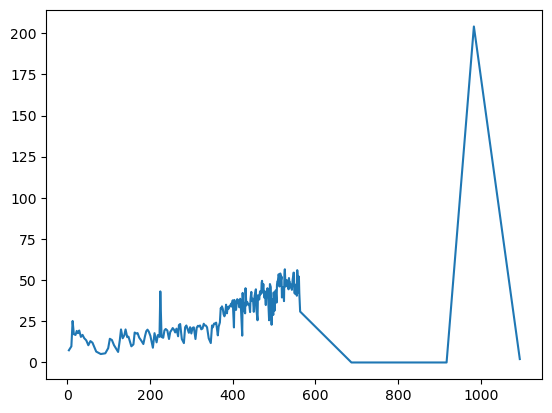

In [44]:
plt.plot(x,y)

In [160]:
from src.preprocessing import feature_pruning
pruned_features = feature_pruning(features, time)
#pruned_features

In [46]:
pruned_features['outcome'] = data_and_outcomes['composite_outcome']
pruned_features.head(2)

,Rf,VT,VE,VO2,VCO2,RQ,O2exp,CO2exp,VE/VO2,VE/VCO2,...,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,interpolated_time,time_start_at_zero,outcome
0,"[18.29, 26.75180308914143, 17.6, 18.1965086571...","[0.452, 0.6209065368829562, 0.549, 0.480135428...","[8.268, 16.642064796540417, 9.66, 8.7045635076...","[189.0858298, 559.7813181269902, 278.319911399...","[138.4675518, 406.25985713515706, 206.59725759...","[0.73, 0.7211426478591703, 0.74, 0.73839956118...","[82.3, 105.23671071014239, 95.99999999999999, ...","[9.5, 18.93893467019352, 14.699999999999998, 1...","[37.0, 26.217279142639605, 30.3, 31.4702629002...","[50.5, 36.14119972906257, 40.8, 42.73582409085...",...,"[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.099999999999998, 22.1, 22.1000000000...","[52.0, 51.99999999999999, 51.99999999999999, 5...","[639.0, 639.0269907884979, 638.9999999999999, ...","[755.0, 755.0, 755.0, 755.0, 755.0, 755.0, 755...","[1.07, 0.8518315233722866, 1.1199999999999999,...","[2.21, 1.351790619599702, 2.29, 1.974617407259...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",False,0.0
4,"[15.5, 14.809999999999999, 16.276026006845886,...","[0.974950132723634, 0.570080673841539, 0.38467...","[15.116, 8.446, 7.295059535106092, 14.38249432...","[497.4793992, 244.6065718, 249.22407477786766,...","[380.230353, 180.1116693, 168.75227230275695, ...","[0.76, 0.7400000000000001, 0.6815828542592595,...","[166.638966199834, 100.14655129023102, 65.4703...","[29.9827760481954, 14.8894057926413, 10.604808...","[28.2, 30.3, 25.17004030261357, 25.62370227604...","[36.9, 41.10000000000001, 36.73956952286325, 3...",...,"[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.500000000000004, 22.5, 2...",NaN,"[649.0, 649.0, 649.0, 649.0000000000001, 649.0...","[760.0, 760.0, 760.0, 760.0000000000001, 760.0...","[1.45, 1.54, 1.5856177229154358, 1.83605408301...","[2.42, 2.5100000000000002, 1.972224460368583, ...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",True,0.0


In [48]:
x = pruned_features['interpolated_time'][0]
y = pruned_features['VE'][0]
spline = np.polyfit(x,y,3)
spline[[0]]

array([-1.6539262e-07])

In [49]:
time_series_features = pd.DataFrame()
for col in pruned_features.iloc[:,0:-3]:
    for idx, row in pruned_features.iterrows():
        try:
            time_series_features.at[idx, col + '_mean'] = np.mean(row[col])
        except:
            time_series_features.at[idx, col + '_mean'] = np.nan
        try:
            time_series_features.at[idx, col + '_max'] = np.max(row[col])
        except:
            time_series_features.at[idx, col + '_max'] = np.nan
        try:
            time_series_features.at[idx, col + '_min'] = np.min(row[col])
        except:
            time_series_features.at[idx, col + '_min'] = np.nan
        try:
            time_series_features.at[idx, col + '_std'] = np.std(row[col])
        except:
            time_series_features.at[idx, col + '_std'] = np.nan
time_series_features

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_27631/480083839.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_series_features.at[idx, col + '_mean'] = np.mean(row[col])
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_27631/480083839.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_series_features.at[idx, col + '_max'] = np.max(row[col])
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_27631/480083839.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

,Rf_mean,Rf_max,Rf_min,Rf_std,VT_mean,VT_max,VT_min,VT_std,VE_mean,VE_max,...,PB_min,PB_std,Ti_mean,Ti_max,Ti_min,Ti_std,Te_mean,Te_max,Te_min,Te_std
0,26.343108,50.043451,6.693317,7.409566,0.817306,1.412597,0.212274,0.229081,21.862376,53.535141,...,755.0,9.504415e-14,0.995927,1.650559,0.137207,0.219165,1.472634,5.120000,0.297896,0.688078
4,19.614454,39.811840,6.092655,6.364680,1.437693,2.867007,0.182088,0.818760,31.405264,101.433000,...,760.0,9.441178e-14,1.377040,2.725223,0.710000,0.324599,2.017309,6.310680,0.771320,0.892687
10,58.432143,430.980933,-99.208942,117.091794,-0.112978,12.462207,-18.777080,5.948967,-57.271659,222.796267,...,768.0,1.701798e-12,1.103423,12.406791,-2.452976,2.030230,3.013339,16.726619,-4.910225,4.298140
65,28.868194,273.182742,-80.721037,77.819433,1.109187,16.276086,-26.921050,8.204924,25.747473,581.842044,...,769.0,5.647887e-13,-1.594959,14.364197,-17.006261,6.382874,0.617950,17.483468,-21.293804,9.628577
66,24.168326,50.850000,8.314214,7.372894,1.071057,2.478000,0.134769,0.391668,26.850003,67.908916,...,760.0,9.430345e-14,1.059486,2.320000,0.370000,0.245523,1.689527,4.930000,0.690000,0.806292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19168,19.402535,47.240000,-10.887953,9.491448,1.713780,5.233529,-0.478015,0.983272,33.479192,124.992000,...,761.0,1.147679e-13,1.261722,5.210000,-0.296907,0.611369,2.887820,20.597104,-0.374348,2.831246
19169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19170,22.783616,47.620000,0.508465,8.307436,1.293571,2.752462,0.302960,0.505078,31.283518,91.491000,...,761.0,8.294139e-14,1.146402,2.545001,0.490448,0.371409,1.916890,7.405464,0.690000,1.070630


In [50]:
# could pad/cut to specific length to have full time series
# fit a spline model and extrapolate the parameters and use those terms as the data <--- WORK ON THIS
# frequency domain features (maybe not as useful)
# dynamic time warping (look up)
# use list of features Narayan sends for time-series
# quartiles/ quantiles of the data

In [51]:
time_series_features['output'] = data_and_outcomes['composite_outcome'].fillna(0)
time_series_features = time_series_features.dropna(thresh=20)
time_series_features

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_27631/3953143525.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_series_features['output'] = data_and_outcomes['composite_outcome'].fillna(0)


,Rf_mean,Rf_max,Rf_min,Rf_std,VT_mean,VT_max,VT_min,VT_std,VE_mean,VE_max,...,PB_std,Ti_mean,Ti_max,Ti_min,Ti_std,Te_mean,Te_max,Te_min,Te_std,output
0,26.343108,50.043451,6.693317,7.409566,0.817306,1.412597,0.212274,0.229081,21.862376,53.535141,...,9.504415e-14,0.995927,1.650559,0.137207,0.219165,1.472634,5.120000,0.297896,0.688078,0.0
4,19.614454,39.811840,6.092655,6.364680,1.437693,2.867007,0.182088,0.818760,31.405264,101.433000,...,9.441178e-14,1.377040,2.725223,0.710000,0.324599,2.017309,6.310680,0.771320,0.892687,0.0
10,58.432143,430.980933,-99.208942,117.091794,-0.112978,12.462207,-18.777080,5.948967,-57.271659,222.796267,...,1.701798e-12,1.103423,12.406791,-2.452976,2.030230,3.013339,16.726619,-4.910225,4.298140,0.0
65,28.868194,273.182742,-80.721037,77.819433,1.109187,16.276086,-26.921050,8.204924,25.747473,581.842044,...,5.647887e-13,-1.594959,14.364197,-17.006261,6.382874,0.617950,17.483468,-21.293804,9.628577,0.0
66,24.168326,50.850000,8.314214,7.372894,1.071057,2.478000,0.134769,0.391668,26.850003,67.908916,...,9.430345e-14,1.059486,2.320000,0.370000,0.245523,1.689527,4.930000,0.690000,0.806292,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19103,28.130446,57.690000,8.953067,10.255420,0.593025,1.397540,0.256980,0.176173,17.077211,37.947000,...,8.460670e-14,1.045445,2.631573,0.370000,0.354377,1.416997,5.172892,0.432063,0.765242,0.0
19107,17.211277,46.510000,-19.173487,6.790479,2.584275,4.566000,-0.198407,1.015591,43.817089,118.897000,...,1.093749e-13,1.370348,9.806264,-1.614586,0.950670,2.624660,14.369006,0.890000,1.570858,0.0
19143,22.120486,53.100000,3.484399,8.736458,1.318394,2.554328,0.029755,0.458215,30.436016,80.018000,...,1.064166e-13,1.277455,5.971501,-0.259734,0.721944,1.971006,8.640904,0.580000,1.201051,0.0
19168,19.402535,47.240000,-10.887953,9.491448,1.713780,5.233529,-0.478015,0.983272,33.479192,124.992000,...,1.147679e-13,1.261722,5.210000,-0.296907,0.611369,2.887820,20.597104,-0.374348,2.831246,0.0


In [68]:
hcm_ts_features = time_series_features[time_series_features.index.isin(hcm_data[1].index)]
hf_ts_features = time_series_features[time_series_features.index.isin(hf_data[1].index)]
cong_ts_features = time_series_features[time_series_features.index.isin(cong_data[1].index)]

In [69]:
time_series_features['output'].value_counts()

output
0.0    2737
1.0     590
Name: count, dtype: int64

In [111]:
from sklearn.model_selection import train_test_split
#stratify to test and train have same percentage of death
#cross-validation for testing hyperparameters <--- IMPORTANT
X = time_series_features[time_series_features.columns.drop('output')].to_numpy()
y = time_series_features['output'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, shuffle=True, random_state=42)

In [112]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, accuracy_score, f1_score
from tqdm import tqdm
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

from pyan import Union
import seaborn as sns

In [113]:
def calc_roc_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:

    # Define thresholds: 1000 equally spaced values between 0 and 1
    thresholds = np.linspace(0, 1, 1000)
    
    # Initialize arrays for FPR and TPR
    fprs = []
    tprs = []
    
    # Loop over each threshold and calculate FPR and TPR
    for threshold in thresholds:
        # Predicted positive based on threshold
        predicted_positive = (y_prob >= threshold).astype(int)
        
        # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
        tp = np.sum((predicted_positive == 1) & (y_true == 1))
        fp = np.sum((predicted_positive == 1) & (y_true == 0))
        fn = np.sum((predicted_positive == 0) & (y_true == 1))
        tn = np.sum((predicted_positive == 0) & (y_true == 0))
        
        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity or recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1 - Specificity
        
        # Append the calculated rates
        tprs.append(tpr)
        fprs.append(fpr)

    fprs = np.array(fprs)
    tprs = np.array(tprs)
    
    return fprs, tprs

In [114]:
def display_roc_curve(
    fpr_tpr_list: list[tuple[np.ndarray, np.ndarray]],
    model_name_list: list[str],
    filename: Union[str, None] = None,
):
    # Plot the ROC curve using seaborn
    sns.set()
    plt.figure()
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    # Plot each ROC curve
    for (fpr, tpr), model_name in zip(fpr_tpr_list, model_name_list):
        plt.plot(fpr, tpr, label=model_name, linewidth=2)
    
    # Add the diagonal line for random performance
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Performance')

    # Set axis labels and title
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

    # Add legend
    plt.legend(fontsize=12, loc='lower right')

    # Adjust layout and save the plot if a filename is provided
    plt.tight_layout()
    if filename:
        plt.savefig(filename, format='png')

    # Show the plot
    plt.show()

In [117]:
#model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, booster='gbtree')
model = XGBClassifier()

In [130]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.7877877877877878
0.152
0.5208256010557136


array([[768,  54],
       [158,  19]])

<Figure size 640x480 with 0 Axes>

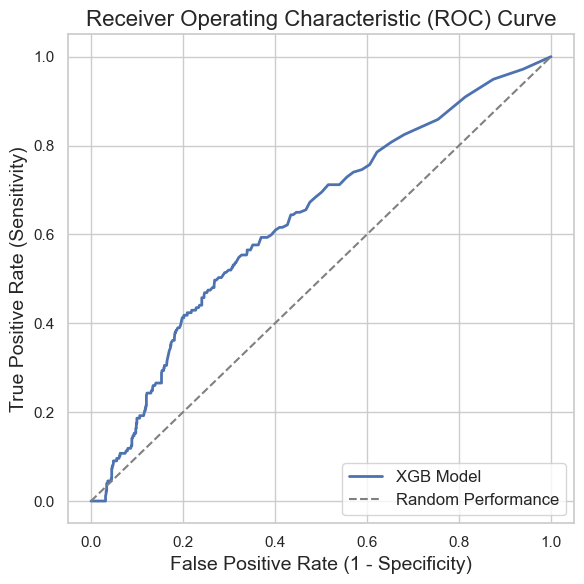

In [134]:
y_prob = model.predict_proba(X_test)[:,1]
fprs, tprs = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fprs, tprs)],["XGB Model"])

In [119]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'max_depth': Integer(4, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

param_space = {
   'learning_rate': (0.01, 1.0, 'log-uniform'),
   'max_depth': (4, 20),
   'gamma': (1e-9, 0.6, 'log-uniform'),
   'n_estimators': (50, 5000),
   'booster': ['gbtree', 'gblinear'],
   'subsample': (0.1, 1.0, 'uniform'),
   'colsample_bytree': Real(0.1, 1.0, 'uniform'),
   'reg_lambda': (1e-9, 100., 'uniform'),
   'reg_alpha': (1e-9, 100., 'uniform')
}

In [120]:
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [121]:
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(X_train, pd.cut(pd.Series(y_train).rank(method='first'), bins=10, labels=False)))

In [124]:
opt = BayesSearchCV(model, search_spaces= search_spaces, n_iter= 50, scoring= 'roc_auc', cv=3)

In [128]:
overdone_control = DeltaYStopper(delta=0.0001) 
time_limit_control = DeadlineStopper(total_time=60*60*4)
#opt.fit(X_train, y_train, callback=[overdone_control, time_limit_control])
opt.fit(X_train, y_train, callback=[time_limit_control])

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'max_depth': Integer(low=4, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')})

In [135]:
print(opt.best_params_)
y_pred = opt.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

OrderedDict({'colsample_bytree': 0.24056432795676522, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 3945, 'reg_alpha': 25.1945402365043, 'reg_lambda': 62.86869229228832, 'subsample': 0.4390397861555796})


array([[822,   0],
       [177,   0]])

<Figure size 640x480 with 0 Axes>

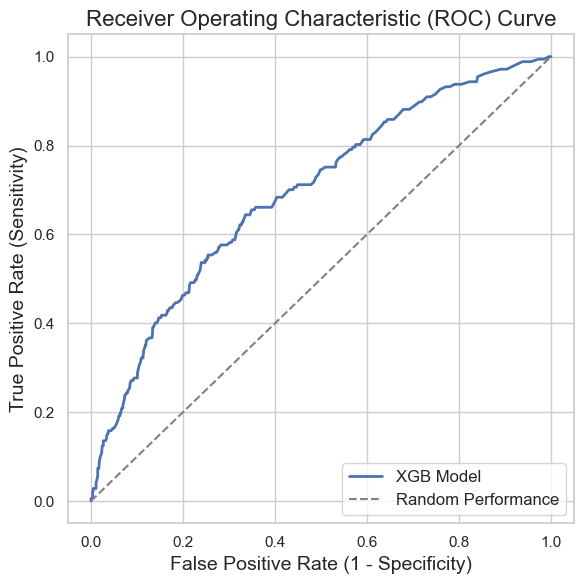

In [136]:
y_prob = opt.best_estimator_.predict_proba(X_test)[:,1]
fprs, tprs = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fprs, tprs)],["XGB Model"])

In [137]:
roc_auc_score(y_test, y_prob)

0.6936952726572918

In [99]:
opt.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.01),
             ('max_depth', 4),
             ('n_estimators', 5000),
             ('reg_alpha', 23.809368298593213),
             ('reg_lambda', 1e-09),
             ('subsample', 0.38855937494535486)])

In [95]:
best_params = opt.best_params_
opt.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.01),
             ('max_depth', 2),
             ('n_estimators', 2107),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 98.98176317519325),
             ('subsample', 0.7730487130010882)])

In [96]:
modelBestHyper = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, booster='gbtree', **best_params)

folds = 10
y_stratified = pd.cut(pd.Series(y_train).rank(method='first'), bins=10, labels=False)
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

predictions = np.zeros(len(X_test))

In [101]:
loss_arr = list()

for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    modelBestHyper.fit(pd.DataFrame(X_train).iloc[train_idx, :], y_train[train_idx])
    val_preds = modelBestHyper.predict(pd.DataFrame(X_train).iloc[val_idx, :])
    val_loss = log_loss(y_true=y_train[val_idx], y_pred=val_preds)
    print(f"Fold {k} Loss: {val_loss:0.5f}")
    loss_arr.append(val_loss)
    predictions += modelBestHyper.predict(X_test).ravel()

/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 0 Loss: 6.16536


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Loss: 6.52106


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Loss: 5.92823


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:17] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Loss: 6.63962


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:19] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 Loss: 6.40249


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:21] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 Loss: 6.30467


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 6 Loss: 6.06675


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 7 Loss: 6.54258


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:27] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 8 Loss: 6.54258


/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:34:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 9 Loss: 6.06675


In [145]:
#y_pred = modelBestHyper.predict(X_test)
y_pred = opt.best_estimator_.predict(X_test)

In [157]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[441, 175],
       [113,  30]])

In [164]:
tn, fp, fn, tp = conf_mat.ravel()

# Calculate precision
precision = tp / (tp + fp)

# Calculate recall (sensitivity)
recall = tp / (tp + fn)

# Calculate specificity
specificity = tn / (tn + fp)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('Specificity: ' + str(specificity))
print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')
print('AUROC: ' + str(auroc))

Precision: 0.14634146341463414
Recall: 0.2097902097902098
Specificity: 0.7159090909090909
Accuracy: 0.813
F1 Score: 0.053
AUROC: 0.511550949050949


In [49]:
values = model.feature_importances_
top_k_features = pd.DataFrame()
feat_coef_dict = dict(zip(time_series_features.columns, values))
top_k = sorted(feat_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[0:20]
top_k_features['feature'] = [i[0] for i in top_k]
top_k_features['importance'] = [i[1] for i in top_k]
top_k_features['abs_importance'] = top_k_features['importance'].abs()
top_k_features
#shapley values instead of imprtance

,feature,importance,abs_importance
0,METS_std,0.054703,0.054703
1,METS_max,0.045619,0.045619
2,HR_max,0.020781,0.020781
3,VO2/Kg_max,0.018651,0.018651
4,VCO2_std,0.016077,0.016077
5,O2exp_max,0.015856,0.015856
6,VE/VCO2_mean,0.015634,0.015634
7,VE/VO2_std,0.015529,0.015529
8,CO2exp_std,0.014123,0.014123
9,VO2/HR_std,0.014000,0.014000


In [50]:
from sklearn.metrics import roc_auc_score

In [51]:
roc_auc_score(y_test, y_pred)

0.5516124956568432

# Cubic Fit

In [52]:
pruned_features

,Rf,VT,VE,VO2,VCO2,RQ,O2exp,CO2exp,VE/VO2,VE/VCO2,...,Phase,Ambient_Temp,RH_Amb,Analyzer_Pressure,PB,Ti,Te,interpolated_time,time_start_at_zero,outcome
0,"[18.29, 26.75180308914143, 17.6, 18.1965086571...","[0.452, 0.6209065368829562, 0.549, 0.480135428...","[8.268, 16.642064796540417, 9.66, 8.7045635076...","[189.0858298, 559.7813181269902, 278.319911399...","[138.4675518, 406.25985713515706, 206.59725759...","[0.73, 0.7211426478591703, 0.74, 0.73839956118...","[82.3, 105.23671071014239, 95.99999999999999, ...","[9.5, 18.93893467019352, 14.699999999999998, 1...","[37.0, 26.217279142639605, 30.3, 31.4702629002...","[50.5, 36.14119972906257, 40.8, 42.73582409085...",...,"[REST, REST, REST, REST, REST, REST, REST, RES...","[22.1, 22.099999999999998, 22.1, 22.1000000000...","[52.0, 51.99999999999999, 51.99999999999999, 5...","[639.0, 639.0269907884979, 638.9999999999999, ...","[755.0, 755.0, 755.0, 755.0, 755.0, 755.0, 755...","[1.07, 0.8518315233722866, 1.1199999999999999,...","[2.21, 1.351790619599702, 2.29, 1.974617407259...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",False,0.0
4,"[15.5, 14.809999999999999, 16.276026006845886,...","[0.974950132723634, 0.570080673841539, 0.38467...","[15.116, 8.446, 7.295059535106092, 14.38249432...","[497.4793992, 244.6065718, 249.22407477786766,...","[380.230353, 180.1116693, 168.75227230275695, ...","[0.76, 0.7400000000000001, 0.6815828542592595,...","[166.638966199834, 100.14655129023102, 65.4703...","[29.9827760481954, 14.8894057926413, 10.604808...","[28.2, 30.3, 25.17004030261357, 25.62370227604...","[36.9, 41.10000000000001, 36.73956952286325, 3...",...,"[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.5, 22.5, 22.5, 22.500000000000004, 22.5, 2...",NaN,"[649.0, 649.0, 649.0, 649.0000000000001, 649.0...","[760.0, 760.0, 760.0, 760.0000000000001, 760.0...","[1.45, 1.54, 1.5856177229154358, 1.83605408301...","[2.42, 2.5100000000000002, 1.972224460368583, ...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",True,0.0
10,"[14.96, 9.017432510918821, 19.731711659387447,...","[0.646496646655018, 0.743277944013596, 0.34857...","[9.673, 8.52520226118146, 6.5324207147679125, ...","[384.0084722, 355.1094357117334, 259.741065269...","[319.77292, 297.258477690566, 200.852681206289...","[0.83, 0.8484884866275205, 0.7687854533594306,...","[104.622327991806, 118.86172203697642, 56.3463...","[26.1045964579944, 31.043683077847035, 13.3512...","[22.5, 22.644854622200352, 19.647874696310875,...","[27.0, 26.891156408232835, 25.561451283400327,...",...,"[NONE, REST, REST, REST, REST, REST, REST, RES...","[25.4, 25.395378491149835, 25.403081005900106,...",NaN,"[639.0, 639.0, 638.9999999999999, 638.99999999...","[768.0, 768.0, 767.9999999999999, 767.99999999...","[1.27, 1.264874991441299, 1.1011944501502453, ...","[2.74, 4.247516775903432, 1.9938777049532665, ...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",False,0.0
65,"[7.41, -3.815142060961671, 9.79, 20.6697039138...","[1.52036827690762, 1.9053424941556572, 1.03805...","[11.262, 13.891989190334579, 10.16, 6.75452522...","[393.7454097, 489.1582709505118, 328.9288157, ...","[307.6961611, 387.46527587523343, 259.5268188,...","[0.78, 0.8126927088270169, 0.7900000000000001,...","[257.269561545132, 324.5498997696384, 178.4469...","[50.57697286024, 61.78172852848574, 32.3243959...","[27.3, 30.000140400163733, 28.8, 34.6295441762...","[34.9, 37.010506887771825, 36.5, 47.0361569950...",...,"[NONE, REST, REST, REST, REST, REST, REST, RES...","[22.8, 22.799999999999997, 22.799999999999997,...",NaN,"[635.0, 634.3915860176253, 635.0000000000001, ...","[769.0, 768.9999999999999, 768.9999999999999, ...","[2.22, 3.863958208204648, 2.73, 1.049237124620...","[5.88, 6.221571372229379, 3.4, 1.8649613990514...","[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...",False,0.0
66,"[10.2, 10.2, 16.676311038293004, 19.93, 16.737...","[0.992, 0.992, 0.4982177811417036, 0.456, 0.29...","[10.122, 10.122, 8.229953414091105, 9.09000000...","[309.1328732, 309.13287

In [53]:
best_fit_features = pd.DataFrame()
interp_time = pruned_features['interpolated_time']
for col in pruned_features.iloc[:,0:-3]:
    for idx, row in pruned_features.iterrows():
        try:
            x = np.array(interp_time[idx]).astype(float)
            y = np.array(row[col]).astype(float)
            cubicFit = np.polyfit(x, y, 3)
            best_fit_features.at[idx, col + '_a'] = cubicFit[0]
            best_fit_features.at[idx, col + '_b'] = cubicFit[1]
            best_fit_features.at[idx, col + '_c'] = cubicFit[1]
            best_fit_features.at[idx, col + '_d'] = cubicFit[1]
        except:
            best_fit_features.at[idx, col + '_a'] = np.nan
            best_fit_features.at[idx, col + '_b'] = np.nan
            best_fit_features.at[idx, col + '_c'] = np.nan
            best_fit_features.at[idx, col + '_d'] = np.nan

best_fit_features

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/2883818935.py:8: RankWarning: Polyfit may be poorly conditioned
  cubicFit = np.polyfit(x, y, 3)
/var/folders/yz/gdzsf62s3rjg

,Rf_a,Rf_b,Rf_c,Rf_d,VT_a,VT_b,VT_c,VT_d,VE_a,VE_b,...,PB_c,PB_d,Ti_a,Ti_b,Ti_c,Ti_d,Te_a,Te_b,Te_c,Te_d
0,-1.002770e-07,0.000081,0.000081,0.000081,-1.588848e-09,1.215974e-07,1.215974e-07,1.215974e-07,-1.653926e-07,0.000133,...,5.554444e-18,5.554444e-18,1.636662e-09,-4.522959e-07,-4.522959e-07,-4.522959e-07,5.754393e-09,-4.495366e-06,-4.495366e-06,-4.495366e-06
4,8.821136e-08,-0.000069,-0.000069,-0.000069,-9.949957e-09,1.720266e-05,1.720266e-05,1.720266e-05,1.250397e-07,0.000047,...,-6.360103e-18,-6.360103e-18,-2.350077e-09,1.539374e-06,1.539374e-06,1.539374e-06,-2.155996e-09,7.175644e-07,7.175644e-07,7.175644e-07
10,-2.979585e-06,0.004088,0.004088,0.004088,1.667333e-07,-2.177164e-04,-2.177164e-04,-2.177164e-04,5.046682e-06,-0.007135,...,-4.940150e-17,-4.940150e-17,6.830417e-08,-8.439741e-05,-8.439741e-05,-8.439741e-05,1.049401e-07,-1.114344e-04,-1.114344e-04,-1.114344e-04
65,1.630567e-06,-0.002265,-0.002265,-0.002265,-3.602655e-08,7.143762e-05,7.143762e-05,7.143762e-05,-8.430342e-07,0.001916,...,-8.068975e-19,-8.068975e-19,5.559297e-08,-1.034081e-04,-1.034081e-04,-1.034081e-04,2.088600e-07,-2.794412e-04,-2.794412e-04,-2.794412e-04
66,-4.418765e-08,0.000031,0.000031,0.000031,-3.511287e-09,2.875418e-06,2.875418e-06,2.875418e-06,-1.719527e-07,0.000170,...,8.162043e-19,8.162043e-19,8.614484e-10,-3.426131e-07,-3.426131e-07,-3.426131e-07,-1.095970e-09,5.579261e-06,5.579261e-06,5.579261e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19168,2.415416e-08,-0.000111,-0.000111,-0.000111,-2.406281e-08,1.744877e-05,1.744877e-05,1.744877e-05,-4.715758e-07,0.000186,...,-7.699539e-18,-7.699539e-18,-4.109236e-09,7.281817e-06,7.281817e-06,7.281817e-06,6.219201e-09,1.439077e-05,1.439077e-05,1.439077e-05
19169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19170,-1.045411e-08,0.000074,0.000074,0.000074,-2.256158e-09,3.564160e-06,3.564160e-06,3.564160e-06,1.742475e-07,0.000042,...,-1.367837e-17,-1.367837e-17,8.635577e-09,-8.682714e-06,-8.682714e-06,-8.682714e-06,3.211197e-08,-3.003313e-05,-3.003313e-05,-3.003313e-05


In [54]:
best_fit_features['output'] = data_and_outcomes['composite_outcome'].fillna(0)
best_fit_features.dropna(thresh=20)

/var/folders/yz/gdzsf62s3rjg09h2ns2j9kv00000gn/T/ipykernel_80158/4116203497.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  best_fit_features['output'] = data_and_outcomes['composite_outcome'].fillna(0)


,Rf_a,Rf_b,Rf_c,Rf_d,VT_a,VT_b,VT_c,VT_d,VE_a,VE_b,...,PB_d,Ti_a,Ti_b,Ti_c,Ti_d,Te_a,Te_b,Te_c,Te_d,output
0,-1.002770e-07,0.000081,0.000081,0.000081,-1.588848e-09,1.215974e-07,1.215974e-07,1.215974e-07,-1.653926e-07,0.000133,...,5.554444e-18,1.636662e-09,-4.522959e-07,-4.522959e-07,-4.522959e-07,5.754393e-09,-4.495366e-06,-4.495366e-06,-4.495366e-06,0.0
4,8.821136e-08,-0.000069,-0.000069,-0.000069,-9.949957e-09,1.720266e-05,1.720266e-05,1.720266e-05,1.250397e-07,0.000047,...,-6.360103e-18,-2.350077e-09,1.539374e-06,1.539374e-06,1.539374e-06,-2.155996e-09,7.175644e-07,7.175644e-07,7.175644e-07,0.0
10,-2.979585e-06,0.004088,0.004088,0.004088,1.667333e-07,-2.177164e-04,-2.177164e-04,-2.177164e-04,5.046682e-06,-0.007135,...,-4.940150e-17,6.830417e-08,-8.439741e-05,-8.439741e-05,-8.439741e-05,1.049401e-07,-1.114344e-04,-1.114344e-04,-1.114344e-04,0.0
65,1.630567e-06,-0.002265,-0.002265,-0.002265,-3.602655e-08,7.143762e-05,7.143762e-05,7.143762e-05,-8.430342e-07,0.001916,...,-8.068975e-19,5.559297e-08,-1.034081e-04,-1.034081e-04,-1.034081e-04,2.088600e-07,-2.794412e-04,-2.794412e-04,-2.794412e-04,0.0
66,-4.418765e-08,0.000031,0.000031,0.000031,-3.511287e-09,2.875418e-06,2.875418e-06,2.875418e-06,-1.719527e-07,0.000170,...,8.162043e-19,8.614484e-10,-3.426131e-07,-3.426131e-07,-3.426131e-07,-1.095970e-09,5.579261e-06,5.579261e-06,5.579261e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19103,-6.748039e-07,0.000576,0.000576,0.000576,-8.917624e-09,8.174307e-06,8.174307e-06,8.174307e-06,-6.669506e-07,0.000597,...,-2.983868e-18,2.471100e-08,-2.225347e-05,-2.225347e-05,-2.225347e-05,6.593968e-09,1.691279e-06,1.691279e-06,1.691279e-06,0.0
19107,-2.402593e-08,0.000024,0.000024,0.000024,-1.191431e-08,1.194928e-05,1.194928e-05,1.194928e-05,-3.338778e-07,0.000357,...,-3.380173e-18,-1.176444e-09,1.611277e-06,1.611277e-06,1.611277e-06,1.173007e-10,7.375719e-06,7.375719e-06,7.375719e-06,0.0
19143,-9.877228e-08,0.000094,0.000094,0.000094,-4.754222e-09,4.174745e-06,4.174745e-06,4.174745e-06,-2.476406e-07,0.000233,...,-2.689110e-18,8.889250e-10,1.714865e-06,1.714865e-06,1.714865e-06,5.706976e-09,-1.879694e-06,-1.879694e-06,-1.879694e-06,0.0
19168,2.415416e-08,-0.000111,-0.000111,-0.000111,-2.406281e-08,1.744877e-05,1.744877e-05,1.744877e-05,-4.715758e-07,0.000186,...,-7.699539e-18,-4.109236e-09,7.281817e-06,7.281817e-06,7.281817e-06,6.219201e-09,1.439077e-05,1.439077e-05,1.439077e-05,0.0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(best_fit_features[best_fit_features.columns.drop('output')].to_numpy(), best_fit_features['output'].to_numpy(), test_size=0.2, random_state=42)
modelBF = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelBF.fit(X_train, y_train)

/opt/miniconda3/envs/cpetai/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [61]:
best_fit_features['output'].value_counts()

output
0.0    3123
1.0     671
Name: count, dtype: int64

In [62]:
y_pred = modelBF.predict(X_test)

In [63]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[601,  15],
       [131,  12]])

In [64]:
tn, fp, fn, tp = conf_mat.ravel()

# Calculate precision
precision = tp / (tp + fp)

# Calculate recall (sensitivity)
recall = tp / (tp + fn)

# Calculate specificity
specificity = tn / (tn + fp)

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('Specificity: ' + str(specificity))

Precision: 0.4444444444444444
Recall: 0.08391608391608392
Specificity: 0.9756493506493507


In [283]:
values = model.feature_importances_
top_k_features = pd.DataFrame()
feat_coef_dict = dict(zip(best_fit_features.columns, values))
top_k = sorted(feat_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[0:20]
top_k_features['feature'] = [i[0] for i in top_k]
top_k_features['importance'] = [i[1] for i in top_k]
top_k_features['abs_importance'] = top_k_features['importance'].abs()
top_k_features

,feature,importance,abs_importance
0,VE/VO2_a,0.026128,0.026128
1,RH_Amb_b,0.026103,0.026103
2,Grade_b,0.024727,0.024727
3,VT_a,0.024574,0.024574
4,VE/VO2_b,0.024134,0.024134
5,VCO2_a,0.023896,0.023896
6,FetCO2_b,0.022997,0.022997
7,FeO2_b,0.022760,0.022760
8,Speed_a,0.022439,0.022439
9,FeCO2_b,0.022309,0.022309


In [284]:
roc_auc_score(y_test, y_pred)

0.5297827172827173